# American Options Pricing Analytics
------------------
> **Idriss Afra**

This project aims to price American options using the Binomial model, the Barone-Adesi & Whaley approximation, and the Least-Squares MC method.

## The Binomial Model

The Binomial model is relatively easy to understand and implement as it assumes that the underlying asset $S_t$ moves up or down by a fixed percentage in each period.

Let's define the movement factors $u$ and $d$ as following :

$$
u = e^{\sigma\sqrt{\Delta t}}\qquad d = e^{-\sigma\sqrt{\Delta t}} \\
$$
Where $\sigma$ is the volatility and $Δt$ is a tiny time step to maturity $T$. The risk-neutral probability under this model is :

$$
p = \frac{e^{(r-q)\Delta t}-d}{u-d} \\
$$
So that :
$$
E(S_{t+\Delta t}) = p × u × S_t + (1 - p) × d × S_t  
= p × S_{t+\Delta t}^u + (1 - p) × S_{t+\Delta t}^d \\
$$

Where $r$ is the zero-coupon interest rate and $q$ the dividend yield.

Once the Binomial tree is simulated, the options are priced using a backward method :

* European Style : 

$$
PV_t(S_t) = e^{-r\Delta t}\left(p\times PV_{t+\Delta t}(S_{t+\Delta t}^u)+(1-p)\times PV_{t+\Delta t}(S_{t+\Delta t}^d)\right)
$$

* American Style :    

$$
PV_t(S_t) = max\left(S_t - K, e^{-r\Delta t}\left(p\times PV_{t+\Delta t}(S_{t+\Delta t}^u)+(1-p)\times PV_{t+\Delta t}(S_{t+\Delta t}^d)\right)\right) \\
$$

With the final condition being : $ PV_T(S) = Max\left(ϕ × (S - K), 0 \right)  $

Where $ϕ = 1$ for call options and $ϕ = -1$ for put options, and $K$ is the strike price.

The accuracy of the binomial model improves with the number of time steps. However, this also raises the complexity and computation time.

In [1]:
import numpy as np
import math

class binomial_model:
    """
    The Binomial model class.
    """
    def __init__(self, n_steps=10**3):
        """
        Init method.
        n_steps is the number of time steps.
        """
        self.n_steps = n_steps
        self.set_data = False
    
    def set_option_data(self, S0, T, vol, r, q=0):
        """
        Setter of option data.
        S0 : spot price
        T : maturity
        vol : ATM implied volatility
        r : zero-coupon interest rate
        q : dividend yield
        """
        # Type / finiteness checks
        for name, val in (("S0", S0), ("T", T), ("vol", vol), ("r", r), ("q", q)):
            if not isinstance(val, (int, float)):
                raise TypeError(f"{name} must be numeric (int or float), got {type(val).__name__}")
            if not np.isfinite(val):
                raise ValueError(f"{name} must be finite (got {val})")
        # Sanity checks
        if S0 <= 0: raise ValueError("S0 must be > 0")
        if T <= 0: raise ValueError("T must be > 0")
        if vol <= 0: raise ValueError("vol must be > 0")
        # Assign attributes
        self.S0 = S0
        self.T = T
        self.vol = vol
        self.r = r
        self.q = q
        self.set_data = True
    
    def spot_simulation(self):
        """
        The spot simulation under the Binomial model.
        The function returns the Binomial tree.
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        # Parameters
        dt = self.T / self.n_steps
        u = math.exp(self.vol * math.sqrt(dt))
        d = 1. / u
        # Spot simulation : Binomial tree
        s = np.zeros((self.n_steps+1, self.n_steps+1))
        s[0,0] = self.S0
        for i in range(1, self.n_steps+1) :
            s[:i,i] = s[:i,i-1] * u
            s[i,i] = s[i-1,i-1] * d

        return s
    
    def binomial_price(self, isCall, K, american=True, debug=False):
        """
        The Binomial price.
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        if (isCall and self.r >= 0 and self.q == 0):
            # The early exercise is no more advantageous
            if debug: print("/!\ Early exercise is not advantageous. Falling back to European price.")
            american = False
        # Parameters
        dt = self.T / self.n_steps
        u = math.exp(self.vol * math.sqrt(dt))
        d = 1. / u
        p = (math.exp((self.r - self.q) * dt) - d) / (u - d)
        # Spot simulation : Binomial tree
        s = np.zeros((self.n_steps+1, self.n_steps+1))
        s[0,0] = self.S0
        for i in range(1, self.n_steps+1) :
            s[:i,i] = s[:i,i-1] * u
            s[i,i] = s[i-1,i-1] * d
        # Option payoff at maturity
        phi = 1 if isCall else -1
        v = np.maximum(phi * (s[:, self.n_steps] - K), 0.)
        # Discount between 2 time steps
        discount = math.exp(-self.r * dt)
        # Backward loop
        for i in range(self.n_steps - 1, -1, -1) : # => i = n_steps-1 ... 0
            n_nodes = i + 1 # i+1 nodes at time step #i
            v = discount * (p * v[:n_nodes] + (1 - p) * v[1:n_nodes+1])
            if american :
                # Possibility of early exercise
                v = np.maximum(phi * (s[:n_nodes, i] - K), v)
        return v[0]

---

## The Barone-Adesi & Whaley Model

The Barone-Adesi & Whaley (BAW) model is an extension of the Black-Scholes model designed to price American options. It works by estimating the optimal early-exercise point, also called the exercise frontier, and approximating a premium to account for the early exercise.
<br>While the BAW model offers a good balance between speed and accuracy, it tends to be less accurate for options with medium maturities, but performs better for short and long term options.

We define the constants : $M = \frac{2r}{σ^2}$, and $N = \frac{2(r-q)}{σ^2}$.

The BAW price of an American option with strike $K$ and maturity $T$ is :

\begin{equation}
\begin{split}
PV_{B.A.W}^{Amr}(K, T) & = PV_{Black}^{Eur}(K, T) + A × \left( \frac{S}{S^*} \right)^b;\space ϕ ×  (S - S^*) < 0 \\
PV_{B.A.W}^{Amr}(K, T) & = ϕ \times (S - K);\space ϕ ×  (S - S^*) \ge 0
\end{split}
\end{equation}

Where :    
- $A = ϕ \times \left( \frac{S^*}{q} \right) × \left( 1 - e^{-qT} N_{(0, 1)} \left(ϕ \times d_1(S^*) \right) \right)$


- $d_1(S) = \frac{log\left(\frac{S}{K}\right) + \left(r - q +  \frac{σ\sqrt T}{2}\right)}{σ\sqrt T}$


- $b = 0.5 × \left(1 - N + ϕ × \sqrt{(1 - N)^2 + 4M/K}  \right)$


- $S^*$ represent the "Optimal Spot" (Exercise Frontier) and is the solution of the following equation :

$$
ϕ × (S - K) = PV_{Black}^{Eur}(K, T) + ϕ × \left( 1 - e^{-qT} N_{(0, 1)} \left(ϕ \times d_1(S) \right) \right) × S / q
$$

Solving the $S^*$ requires numerical methods as its equation has no closed-form solution. In this project, we apply the Bisection method.

More details can be found in [Barone-Adesi-Whaley 1987](https://github.com/Idriss-Afra/American-Options-Pricing-Analytics/blob/main/Barone-Adesi-Whaley%201987.pdf).

In [2]:
from scipy.stats import norm
from scipy import optimize

class baw_model :
    """
    The Barone-Adhesi & Whaley model class.
    """
    def __init__(self):
        """
        Init method.
        """
        self.set_data = False

    def set_option_data(self, S0, T, vol, r, q=0):
        """
        Set option data method
        S0 : spot price
        T : maturity
        vol : ATM implied volatility
        r : zero-coupon interest rate
        q : dividend yield
        """
        # Type / finiteness checks
        for name, val in (("S0", S0), ("T", T), ("vol", vol), ("r", r), ("q", q)):
            if not isinstance(val, (int, float)):
                raise TypeError(f"{name} must be numeric (int or float), got {type(val).__name__}")
            if not np.isfinite(val):
                raise ValueError(f"{name} must be finite (got {val})")
        # Sanity checks
        if S0 <= 0: raise ValueError("S0 must be > 0")
        if T <= 0: raise ValueError("T must be > 0")
        if vol <= 0: raise ValueError("vol must be > 0")
        # Assign attributes
        self.S0 = S0
        self.T = T
        self.vol = vol
        self.r = 1e-4 if r==0 else r  # 0.01% -- to avoid division by zero
        self.q = q
        self.set_data = True

    def d1(self, S, K):
        """
        The Black-Scholes d1 formula.
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        v2T = self.vol**2 * self.T
        return (np.log(S / K) + (self.r - self.q) * self.T + v2T / 2) / v2T**0.5

    def black_price(self, isCall, S, K):
        """
        The Black-Scholes price.
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        v2T = self.vol**2 * self.T
        d_1 = self.d1(S, K)
        d_2 = d_1 - v2T**0.5
        phi = 1 if isCall else  -1
        return phi * (S * math.exp(-self.q * self.T) * norm.cdf(phi * d_1) - K * math.exp(-self.r * self.T) * norm.cdf(phi * d_2))

    def _abs_black_delta(self, isCall, S, K):
        """
        The Black-Scholes absolute delta.
        /!\ For internal use only
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        phi = 1 if isCall else  -1
        return math.exp(-self.q * self.T) * norm.cdf(phi * self.d1(S, K))

    def _american_adj(self, isCall, S, S_optimal, K):
        """
        The American adjustment formula such as : American_Black_Price = European_Black_Price + American_Adj.
        /!\ For internal use only
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        phi = 1 if isCall else  -1
        M = 2 * self.r / self.vol**2
        N = 2 * (self.r - self.q) / self.vol**2
        a = 1 - math.exp(-self.r * self.T)
        b = 0.5 * (1 - N + phi * math.sqrt((1 - N)**2 + 4 * M / a))
        return phi * (S_optimal / b) * (1 - self._abs_black_delta(isCall, S_optimal, K)) * (S / S_optimal)**b

    def optimal_spot(self, isCall, K, n_max=750, n_stdev=5, debug=False):
        """
        Bisection method to find the Optimal Spot S*.
        """
        # Computation of S_min and S_max
        S_min = 1e-4 * K
        S_max = K * math.exp(n_stdev * self.vol * math.sqrt(self.T))
        S_min = K if isCall else S_min
        S_max = S_max if isCall else K
        f_min = self._obj_func(isCall, S_min, K)
        f_max = self._obj_func(isCall, S_max, K)
        # Ensure that f_min and f_max have opposite signs
        if f_min * f_max > 0:
            factor = 1.5
            attempts = 0
            while f_min * f_max > 0 and attempts < 30:
                S_min = max(1e-4, S_min / factor)
                S_max = S_max * factor
                f_min = self._obj_func(isCall, S_min, K)
                f_max = self._obj_func(isCall, S_max, K)
                attempts += 1
        if f_min * f_max > 0:
            if debug: print("/!\ Bisection method failed to converge and find the optimal spot level.")
            return None
        # Bisection
        n = 1
        while n <= n_max :
            optimal_spot = (S_min + S_max)  / 2
            f_mid = self._obj_func(isCall, optimal_spot,  K)
            if (abs(f_mid) < 1e-12) or (abs(S_max - S_min) < 1e-10) :
                return optimal_spot
            if f_mid * f_min < 0.0 :
                S_max = optimal_spot
                f_max = f_mid
            else :
                S_min = optimal_spot
                f_min = f_mid
            n += 1
        if debug: print("/!\ Bisection methods failed to converge and find the optimal spot level.")
        return None

    def _obj_func(self, isCall, S, K):
        """
        The Optimal Spot S* Equation.
        /!\ For internal use only
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        phi = 1 if isCall else  -1
        return self.black_price(isCall, S, K) + self._american_adj(isCall, S, S, K) - phi * (S - K)

    def _obj_func_deriv(self, isCall, S, K):
        """
        The derivative of the Optimal Spot S* Equation.
        /!\ For internal use only
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        phi = 1 if isCall else  -1
        M = 2 * self.r / self.vol**2
        N = 2 * (self.r - self.q) / self.vol**2
        a = 1 - math.exp(-self.r * self.T)
        b = 0.5 * (1 - N + phi * math.sqrt((1 - N)**2 + 4 * M / a))
        delta = phi * self._abs_black_delta(isCall, S, K)

        return delta * (1 - 1 / b) + phi * (1 / b) * (1 - phi * math.exp(-self.q * self.T) * norm.pdf(phi * self.d1(S, K)) / (self.vol * math.sqrt(self.T))) - phi

    def baw_price(self, isCall, K, debug=False):
        """
        The B.A.W price.
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        if (isCall and self.r >= 0 and self.q == 0):
            # The early exercise is no more advantageous
            if debug: print("/!\ Early exercise is not advantageous. Falling back to European price.")
            return self.black_price(isCall, self.S0, K)
        else :
            phi = 1 if isCall else  -1
            S_optimal = self.optimal_spot(isCall, K, debug=debug)
            if debug: print(f"/!\ Optimal Spot S* = {S_optimal}")
            if S_optimal is None:
                # Fallback to European price
                if debug: print("/!\ Could not determine optimal spot level. Falling back to European price.")
                return self.black_price(isCall, self.S0, K)
            exercise_cond = phi * (self.S0 - S_optimal) > 0
            return max(phi * (self.S0 - K), 0) if exercise_cond else self.black_price(isCall, self.S0, K) + self._american_adj(isCall, self.S0, S_optimal, K)

---

## The Least-Squares Monte-Carlo Method

The Least-Squares Monte-Carlo method was designed by Longstaff & Schwartz. It is a very interesting and a brilliant pricing method for American and Bermudan payoffs. However, it relies on heavy numerical algorithms which increases its instability and complexity.

First, the spot prices are simulated $M$ times via its Black-Scholes solution :    

$$
S_{t+dt} = S_{t} \times exp\left(\left(r - \frac{\sigma^2}{2}\right) dt + \sigma dW_t \right)
$$

Where : $dt=\frac{T}{N}$ with $N$ being the number of time steps, and $(W_t)_t$ a serie of standard brownian motions.

Then, the American options are priced using a backward loop using the following steps :

1 - We perform a regression method between spot prices simulated at step $t$ and discounted option prices computed at step $t + dt$. In this project, we use a $3$ degree, $4$ coefficients, polynomial regression for $M=5×10^5$ and compute the coefficients $(a_i)_i$ such as :

$$
∀j∈[1,\space 50000], \space  DF_{t,\space t+dt} × PV_{t+dt}(S^{j}_{t+dt}) = ∑_{i=0}^{3}a_i× \left(S^{j}_{t}\right)^i
$$

Regressing on moneyness provides proper scaling and enhances numerical stability.

2 - Then, we compute the continuation price using the solved coefficients :

$$
 C_{t}\left(S^{j}_{t}\right) = ∑_{i=0}^{3}a_i×\left(S^{j}_{t}\right)^i
$$

In fact, we fit a single continuation-value function across all paths at a given time step to estimate the conditional expectation of the next discounted payoff based solely on the current state. Since each Monte Carlo path reveals only one future, we pool the cross-section of paths to approximate the range of possible futures and learn that expectation.

3 - Finally, we compute the option prices at step $t$ considering the possibility of early exercise :

\begin{equation}
\begin{split}
PV_{t}\left(S^{j}_{t}\right) & = DF_{t,\space t+dt} × PV_{t+dt}\left(S^{j}_{t+dt}\right); \space  C_{t}\left(S^{j}_{t}\right) > ϕ × \left(S^{j}_{t} - K\right) \\ \\
& = ϕ × \left(S^{j}_{t} - K\right);\space C_{t}\left(S^{j}_{t}\right) \le ϕ × \left(S^{j}_{t} - K\right)
\end{split}
\end{equation}

With the final condition being : $ PV_T(S) = Max\left(ϕ × (S - K), 0 \right) $

To enhance numerical stability and accuracy, we adopt three practical refinements. First, at each time step we perform the regression only on in-the-money (ITM) paths, since the continuation value is most informative where early exercise is relevant; this reduces bias from near-zero payoffs and improves the fit. Second, we regularize the polynomial regression with a small ridge (Tikhonov) penalty to mitigate variance and multicollinearity among basis functions, yielding more stable continuation estimates. Finally, we apply a control variate using the corresponding European option priced in closed form under Black–Scholes: we adjust the pathwise American estimates by their covariance with the European payoff, thereby substantially reducing Monte Carlo variance without introducing bias.


More details can be found in [Longstaff-Schwartz Least-Squares MC Approach](https://github.com/Idriss-Afra/American-Options-Pricing-Analytics/blob/main/Longstaff-Schwartz%20Least-Squares%20MC%20Approach.pdf).






In [3]:
class lms_model :
    """
    The Least-Squares Monte-Carlo Method For American Options.
    """
    def __init__(self, n_simul=5*10**4, n_steps=100, reg_order=3, control_variate=True, seed=10):
        """
        Init method.
        n_simul : number of simulations
        n_steps : number of time steps
        reg_order : order of the polynomial regression
        """
        self.n_simul = n_simul
        self.n_steps = n_steps
        self.reg_order = reg_order
        self.control_variate = control_variate
        self.rng = np.random.default_rng(seed)
        self.set_data = False
        

    def set_option_data(self, S0, T, vol, r, q=0):
        """
        Setter of option data.
        S0 : spot price
        T : maturity
        vol : ATM implied volatility
        r : zero-coupon interest rate
        q : dividend yield
        """
        # Type / finiteness checks
        for name, val in (("S0", S0), ("T", T), ("vol", vol), ("r", r), ("q", q)):
            if not isinstance(val, (int, float)):
                raise TypeError(f"{name} must be numeric (int or float), got {type(val).__name__}")
            if not np.isfinite(val):
                raise ValueError(f"{name} must be finite (got {val})")
        # Sanity checks
        if S0 <= 0: raise ValueError("S0 must be > 0")
        if T <= 0: raise ValueError("T must be > 0")
        if vol <= 0: raise ValueError("vol must be > 0")
        # Assign attributes
        self.S0 = S0
        self.T = T
        self.vol = vol
        self.r = r
        self.q = q
        self.set_data = True

    def set_path(self) :
        """
        Monte-Carlo Simulation under the Black-Scholes model : n_steps x n_simul.
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        # Generate random N(0,1) (Nb of time steps x Nb of simulations)
        normal = self.rng.normal(0, 1, (self.n_steps, self.n_simul))
        # Time steps vector
        self.dt = self.T / self.n_steps
        sqrt_dt = math.sqrt(self.dt)
        # S array (Nb of time steps x Nb of simulations)
        self.S = np.empty(shape=(self.n_steps + 1, self.n_simul))
        self.S[0,:] = self.S0
        # The drift mu : r - q
        mu = self.r - self.q
        # Spot simulations from t to t + dt
        for j in range(self.n_steps) :
            self.S[j+1,:] = self.S[j,:] * np.exp((mu - 0.5 * self.vol**2) * self.dt + self.vol * sqrt_dt * normal[j,:])

    def _analytical_euro_price(self, isCall, K) :
        """
        The analytical European Black-Scholes price.
        /!\ For internal use only
        """
        if self.set_data == False :
            print("Please set option data first.")
            return None
        phi = 1 if isCall else -1
        d_1 = (np.log(self.S0 / K) + (self.r - self.q + 0.5 * self.vol**2) * self.T) / (self.vol * math.sqrt(self.T))
        d_2 = d_1 - self.vol * math.sqrt(self.T)
        return phi * (self.S0 * math.exp(-self.q * self.T) * norm.cdf(phi * d_1) - K * math.exp(-self.r * self.T) * norm.cdf(phi * d_2))
    
    def lsm_price(self, isCall, K, debug=False):
        """
        The Monte-Carlo American Price.
        """
        if self.set_data == False :
            print("Please set option data first : \"set_option_data\" method.")
            return None
        if not hasattr(self, 'S') :
            print("Please run spot simulations first : \"set_path\" method")
            return None
        if (isCall and self.r >= 0 and self.q == 0):
            # The early exercise is no more advantageous
            if debug: print("/!\ Early exercise is not advantageous. Falling back to European price.")
            return self._analytical_euro_price(isCall, K)
        # Option payoff at maturity
        phi = 1 if isCall else -1
        exercise_prices = np.maximum(phi * (self.S - K), 0)
        df = math.exp(-self.r * self.dt)
        # Backward loop
        prices = np.empty(shape=(self.n_steps + 1, self.n_simul))
        prices[-1,:] = exercise_prices[-1,:]
        for j in range(self.n_steps - 1, 0, -1):
            # Identify in-the-money paths at time j (strictly ITM)
            itm_mask = (phi * (self.S[j, :] - K)) > 0
            n_itm = int(np.sum(itm_mask))
            deg = self.reg_order
            if n_itm >= deg + 1:
                # Regress on S/K - 1 (scaled data) for numerical stability
                x_itm = self.S[j, itm_mask] / K - 1.0
                y_itm = df * prices[j + 1, itm_mask]   
                # Build Vandermonde matrix for degree up to deg
                X = np.vander(x_itm, N=deg + 1, increasing=True) 
                # Small ridge to stabilize regression -> reduce variance and multicollinearity
                lam = 1e-4
                D = np.eye(X.shape[1])
                D[0, 0] = 0.0  # <-- We don't penalize beta_0
                beta, *_ = np.linalg.lstsq(X.T @ X + lam * D, X.T @ y_itm, rcond=None)
                # Evaluate continuation on ALL paths at time j
                x_all = self.S[j, :] / K - 1.0
                X_all = np.vander(x_all, N=deg + 1, increasing=True)
                continuation_prices = X_all @ beta
            else:
                # Not enough ITM points to fit a deg-polynomial -> fallback to df * next_price
                continuation_prices = df * prices[j + 1, :]
            # Sanity check to avoid negative continuation values
            continuation_prices = np.maximum(continuation_prices, 0.0)
            # Possibility of early exercise
            exercise_now = itm_mask & (exercise_prices[j,:] > continuation_prices)
            prices[j,:] = np.where(exercise_now, exercise_prices[j,:], df * prices[j + 1,:])
        # LSM simulated prices at time 0 (/!\ excluding possibility of exercise at time 0)
        prices[0,:] = df * prices[1,:]
        v_american_mc = prices[0,:]
        # Control variate via the corresponding European option price
        if self.control_variate :
            if debug: print("/!\ Applying Control Variate technique.")
            # European option price under MC
            v_euro_mc = math.exp(-self.r * self.T) * np.maximum(phi * (self.S[-1,:] - K), 0)
            # Analytical European option price (BS formula)
            v_euro_bs = self._analytical_euro_price(isCall, K)
            # Control variate adjustment
            v_euro_var = np.var(v_euro_mc, ddof=1)
            if v_euro_var > 0 :
                cov = np.cov(v_american_mc, v_euro_mc, ddof=1)[0,1]
                theta = cov / v_euro_var
                if (v_euro_bs < 1e-8 or v_euro_var < 1e-8) :
                    if debug: print("/!\ Control Variate skipped due to very low European price or its variance.")
                    return np.maximum(np.mean(v_american_mc), phi * (self.S0 - K))
                se_plain = np.std(v_american_mc, ddof=1) / np.sqrt(self.n_simul)
                se_cv    = np.std(v_american_mc - theta*(v_euro_mc - v_euro_bs), ddof=1) / np.sqrt(self.n_simul)
                if debug: print(f"/!\ Control Variate applied : SE Before = {se_plain:.6f} | SE After = {se_cv:.6f}")
                # Adjust LSM price
                v_american_mc -= theta * (v_euro_mc - v_euro_bs)
        # LSM final price
        return np.maximum(np.mean(v_american_mc), phi * (self.S0 - K))

---

## Numerical Application

Let’s illustrate and compare the three pricing methods:

Input Data :  {'Contract Size': 100.0, 'Spot Price': 120.0, 'Maturity': 1.0, 'ATM Implied Volatility': 0.35, 'ZC Rate': 0.038, 'Dividend Yield': 0.015}


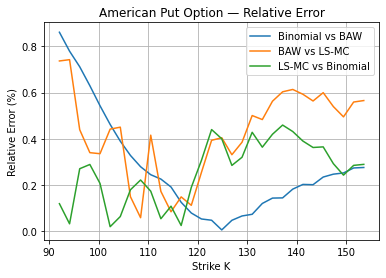

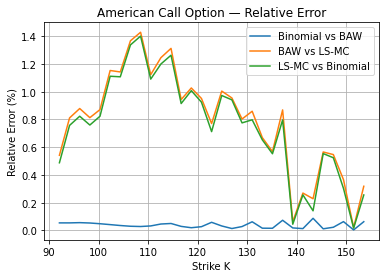

In [4]:
import matplotlib.pyplot as plt

# Data
N = 100.
S0 = 120.
T = 1.0
vol = 0.35
r = 0.038
q = 0.015
F = S0 * math.exp((r - q) * T)
data = {"Contract Size" : N, "Spot Price" : S0, "Maturity" : T, "ATM Implied Volatility" : vol, "ZC Rate" : r, "Dividend Yield" : q}
print("Input Data : ", data)
# Models Initialization
binomial = binomial_model()
binomial.set_option_data(S0, T, vol, r, q)
baw = baw_model()
baw.set_option_data(S0, T, vol, r, q)
lsm = lms_model()
lsm.set_option_data(S0, T, vol, r, q)
lsm.set_path()
# Compute price curves vs Strike K
def price_curves_vs_strike(isCall, min_factor=0.75, max_factor=1.25, n_points=31):
    K_grid = np.linspace(min_factor * F, max_factor * F, n_points)
    px_binomial = []
    px_baw = []
    px_lsm = []
    for K in K_grid:
        px_binomial.append(N * binomial.binomial_price(isCall, K))
        px_baw.append(N * baw.baw_price(isCall, K))
        px_lsm.append(N * lsm.lsm_price(isCall, K))
    return K_grid, np.array(px_binomial), np.array(px_baw), np.array(px_lsm)
put_K_grid, put_binom, put_baw, put_lsm = price_curves_vs_strike(isCall=False)
call_K_grid, call_binom, call_baw, call_lsm = price_curves_vs_strike(isCall=True)
# Put
plt.figure()
plt.plot(put_K_grid, 100 * np.abs(put_baw / put_binom - 1), label="Binomial vs BAW")
plt.plot(put_K_grid, 100 * np.abs(put_lsm / put_baw - 1),  label="BAW vs LS-MC")
plt.plot(put_K_grid, 100 * np.abs(put_lsm / put_binom - 1), label="LS-MC vs Binomial")
plt.title("American Put Option — Relative Error")
plt.xlabel("Strike K")
plt.ylabel("Relative Error (%)")
plt.legend()
plt.grid(True)
# Call
plt.figure()
plt.plot(call_K_grid, 100 * np.abs(call_baw / call_binom -1), label="Binomial vs BAW")
plt.plot(call_K_grid, 100 * np.abs(call_lsm / call_baw - 1),  label="BAW vs LS-MC")
plt.plot(call_K_grid, 100 * np.abs(call_lsm / call_binom -1), label="LS-MC vs Binomial")
plt.title("American Call Option — Relative Error")
plt.xlabel("Strike K")
plt.ylabel("Relative Error (%)")
plt.legend()
plt.grid(True)
plt.show()